# TOC -> nbextensions

In [1]:
import numpy as np
import scipy.fft
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import clear_output, display, HTML
from ipywidgets import interactive as interactive
import cv2

%matplotlib inline

## Going from time to 1d space

### Stack time frames to become a 1d image
Let's have a look at our flickering signal again.

In [2]:
T = 4               # seconds
sampling_rate = 32  # sample per sec
nT = int(sampling_rate*T)

# Define time vector
t = np.linspace(0, T, nT, endpoint=False)

def sinusoid(frequency, times=t, amplitude=1, phase=0, mean=0):
    return amplitude * np.cos(2*np.pi*frequency*times + phase) + mean

# Produce sinusoidal luminance (L) signal
sfrequency = 1
L = sinusoid(frequency=sfrequency)

In [3]:
def animate_flicker(waveform, times, sampling_rate):
    fig, ax = plt.subplots()
    img = ax.imshow(np.zeros((3,3)), cmap="gray", vmin=-1, vmax=1, animated=True)
    plt.axis('off')
    
    def animate(frame_num):
        img_array = img.get_array()
        img_array[1,1] = waveform[frame_num-1]
        img.set_array(img_array)
        return (img, )
    
    display(HTML(FuncAnimation(fig, animate, blit=True, frames=len(waveform),
                               interval=1000/sampling_rate).to_jshtml()))
    plt.close()

In [4]:
animate_flicker(L, t, sampling_rate)

Imagine that rather than playing all the frames of our flickering light animation
one after the other and instead took (some of) these frames and placed them next to each other.

Since the pattern across frames is the same as when we played it as animation,
we can still describe these frames as a sinusoidal signal --
see how the (relative) intensity in each frame is still indicated by the height of the waveform:

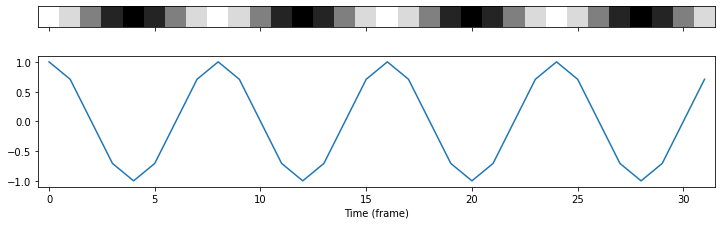

In [5]:
idc = np.arange(0, nT, sampling_rate/8).astype(int)

fig, axes = plt.subplots(2,1, sharex="all", figsize=(10, 4))
axes[0].imshow(L[idc] * np.ones((1, len(idc))), cmap="gray", vmin=-1, vmax=1)
axes[0].yaxis.set_visible(False)
axes[1].plot(L[idc]), axes[1].set_xlabel("Time (frame)")
fig.tight_layout()
plt.show()

Now let's take all our frames and put them side-by-side this way.
It will be a lot frames, and the intensity change from one to another is small
so you won't be able to really see the border between one frame and its neighbor anymore.

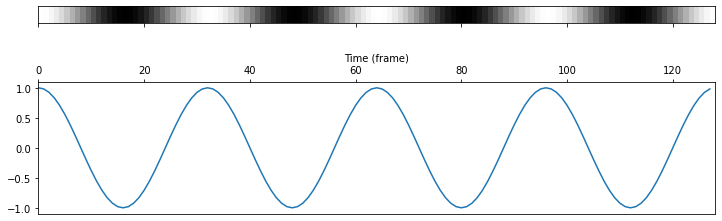

In [6]:
fig, axes = plt.subplots(2,1, sharex="all", figsize=(10, 4))
axes[0].imshow(L * np.ones((1, nT)), cmap="gray", vmin=-1, vmax=1, extent=(0, nT, 0, nT/40))
axes[0].yaxis.set_visible(False), axes[0].xaxis.tick_bottom()

axes[1].plot(L)
axes[1].set_xlabel("Time (frame)"), axes[1].xaxis.tick_top(), axes[1].xaxis.set_label_position("top")
fig.tight_layout()
plt.show()

The signal is still perfectly described by the waveform
-- but now it instead of flickering light, it looks like a grating!
Instead of changing contrast over _time_ (flickering),
is represented such that contrast changes over _space_.

How should we think about this?

Let's remind ourselves of some aspects of our signal:

In [7]:
print(f"Frequency is {sfrequency} cycle(s) per second")
print(f"Sampling rate is {sampling_rate} frames per cycle/second")
print(f"Duration is {T} second(s)")
print(f"= {sfrequency*T} cycle(s) per signal, sampled with {nT} frames")

Frequency is 1 cycle(s) per second
Sampling rate is 32 frames per cycle/second
Duration is 4 second(s)
= 4 cycle(s) per signal, sampled with 128 frames


Well, _we_ decided each sample represents a temporal frame.
We can also decided that each sample represents a pixel:

In [8]:
print(f"{sampling_rate} frames per cycle becomes {sampling_rate} pixels per cycle")
print(f"{nT} frames becomes {nT} pixels per signal")
print(f"{sfrequency*T} cycle(s) stays {sfrequency*T} cycle(s) per signal")

32 frames per cycle becomes 32 pixels per cycle
128 frames becomes 128 pixels per signal
4 cycle(s) stays 4 cycle(s) per signal


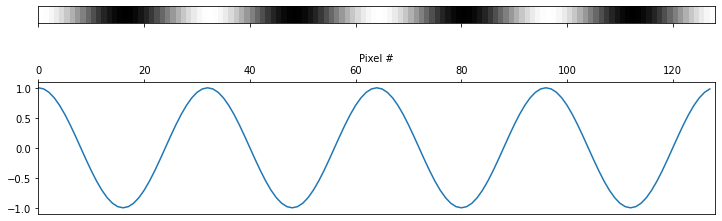

In [9]:
fig, axes = plt.subplots(2,1, sharex="all", figsize=(10, 4))
axes[0].imshow(L * np.ones((1, nT)), cmap="gray", vmin=-1, vmax=1, extent=(0, nT, 0, nT/40))
axes[0].yaxis.set_visible(False)

axes[1].plot(L)
axes[1].set_xlabel("Pixel #"), axes[1].xaxis.tick_top(), axes[1].xaxis.set_label_position("top")
fig.tight_layout()
plt.show()

### Spatial frequency: cycles per image; cycles per degree

The least simple of this, is how to express the now _spatial_ frequency.
We can of course just express the total number of _cycles per image_
or as _pixels per cycle_:

In [10]:
print(f"{sfrequency * T} cycle(s) per image")
print(f"{sampling_rate} pixels per cycle")

4 cycle(s) per image
32 pixels per cycle


However, neither the size of the image nor of a single cycle is defined in an actual physical unit yet
(such as seconds for the temporal signal).
As physical unit, we could use cm, inches, etc.

In vision science, the logical choice is _degrees of visual angle_.
As a result, our unit of frequency becomes _cycles per degree of visual angle_, or _cpd_ for short.

Similarly, the sampling rate is now not _frames per second_,
but _pixels per degree of visual angle_, or _ppd_ for short.

In [11]:
print(f"Frequency is {sfrequency} cycle(s) per degree (instead of {sfrequency} cycle(s) per second)")
print(f"Sampling rate is {sampling_rate} pixels per degree (instead of {sampling_rate} frames per second)")
print(f"Visual extent is {T} degree(s) (instead of a duration of {T} seconds)")
print(f"= {sfrequency*T} cycle(s) per signal, sampled with {nT} pixels")

Frequency is 1 cycle(s) per degree (instead of 1 cycle(s) per second)
Sampling rate is 32 pixels per degree (instead of 32 frames per second)
Visual extent is 4 degree(s) (instead of a duration of 4 seconds)
= 4 cycle(s) per signal, sampled with 128 pixels


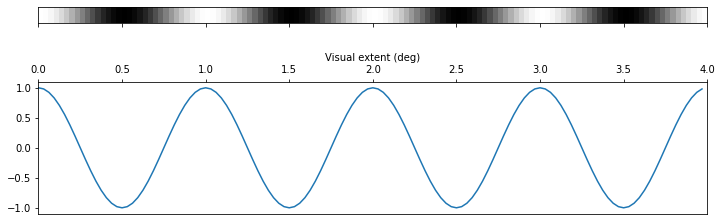

In [12]:
fig, axes = plt.subplots(2,1, sharex="all", figsize=(10, 4))
axes[0].imshow(L * np.ones((1, nT)), cmap="gray", vmin=-1, vmax=1, extent=(0, T, 0, T/40))
axes[0].yaxis.set_visible(False)

axes[1].plot(t, L)
axes[1].set_xlabel("Visual extent (deg)"), axes[1].xaxis.tick_top(), axes[1].xaxis.set_label_position("top")
fig.tight_layout()
plt.show()

### Fourier transform in 1d-space
The nice thing is that the Fourier transform does not care about any of these units,
or even whether your signal is in time or space!

We can take the exact same Fourier transform of our signal and plot the spectrum;
the only thing we need to change is the axis labels.

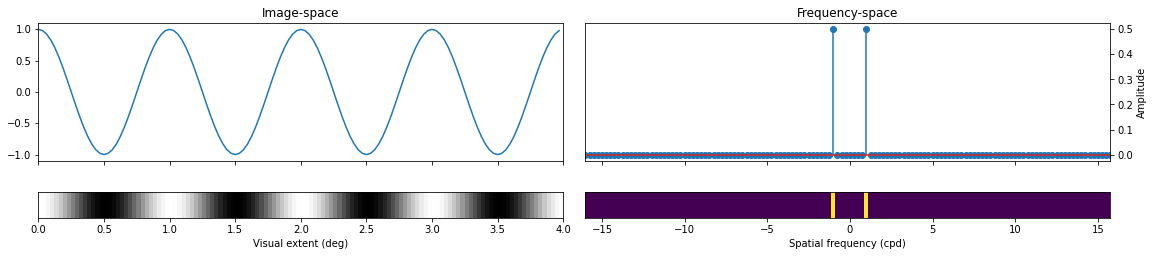

In [13]:
fL = scipy.fft.fftshift(scipy.fft.fftfreq(nT, d=(1/sampling_rate)))
FL = scipy.fft.fftshift(scipy.fft.fft(L))
FL_amp = np.abs(FL) / nT

fig, axes = plt.subplots(2, 2, sharex="col", figsize=(16, 4))
axes[0,0].plot(t, L)

axes[0,1].stem(fL, FL_amp)
axes[0,1].yaxis.tick_right(), axes[0,1].yaxis.set_label_position("right")
axes[0,1].set_ylabel("Amplitude"), axes[0,0].set_title("Image-space")

axes[1,0].imshow(L * np.ones((1, nT)), cmap="gray", vmin=-1, vmax=1, extent=(0, T, 0, T/20))
axes[1,0].yaxis.set_visible(False)
axes[1,0].set_xlabel("Visual extent (deg)")

axes[1,1].imshow(FL_amp * np.ones((1, nT)), extent=(fL.min(), fL.max(), 0, np.max(fL)/10))
axes[1,1].yaxis.set_visible(False)
axes[1,1].set_xlabel("Spatial frequency (cpd)"), axes[0,1].set_title("Frequency-space")

fig.tight_layout()
plt.show()

**Going from temporal to spatial frequency is just a relabeling of axes and units!**

## From 1d to 2d space

### Repeating 1d sine-wave
Let's start with sine-waves again and simply repeat our previous signal by repeating its rows.

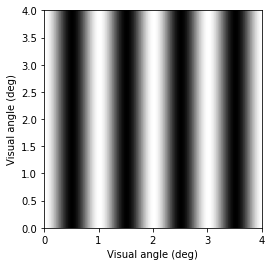

In [14]:
L_2d = np.repeat(np.expand_dims(L, 0), nT, axis=0)
Lextent = (0, T,)

plt.figure(figsize=(4, 4))
plt.imshow(L_2d, cmap='gray', extent=Lextent*2)
plt.xlabel('Visual angle (deg)'), plt.ylabel('Visual angle (deg)')
plt.show()

### Fourier transform in 2d-space
The Fourier transform in 2d-space is equal to taking the Fourier transform in both dimensions.
Let's see why that is the case.

(Note: we look at the cosine component in the following because the sine component is comparatively tiny)

In [15]:
# Compute fft in x-direction
FL_x = scipy.fft.fft2(L_2d, axes=1)
cosine_x = np.fft.fftshift(FL_x).real / nT

# Compute fft in y-direction
FL_y = scipy.fft.fft2(L_2d, axes=0)
cosine_y = np.fft.fftshift(FL_y).real / nT

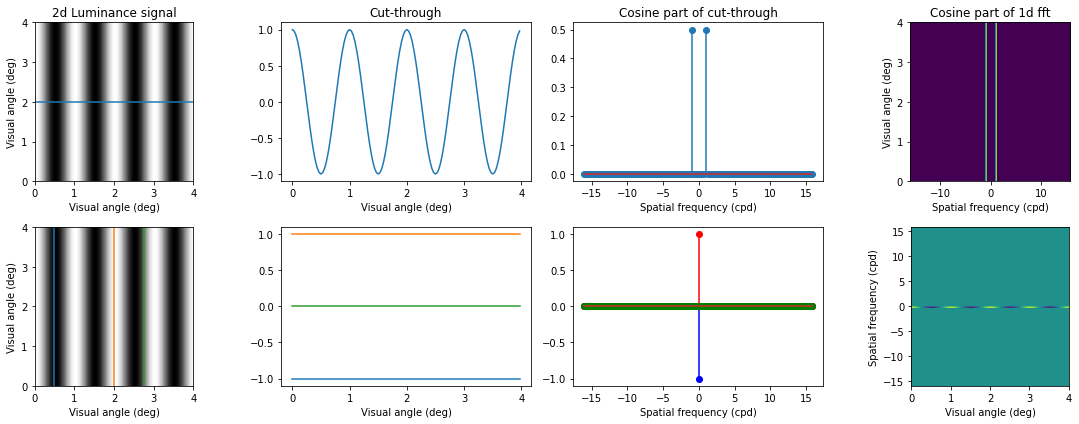

In [16]:
v1, v2, v3 = 0.5, 2, 2.75

fig, axes = plt.subplots(2, 4, figsize=(16, 6))
axes[0,0].imshow(L_2d, cmap='gray', extent=Lextent*2)
axes[0,0].plot(Lextent, (T/2, T/2))
axes[0,0].set_xlabel('Visual angle (deg)'), axes[0,0].set_ylabel('Visual angle (deg)')
axes[0,1].plot(t, L), axes[0,1].set_xlabel('Visual angle (deg)')
axes[0,2].stem(fL, cosine_x[10, :]), axes[0,2].set_xlabel('Spatial frequency (cpd)')
axes[0,3].imshow(cosine_x, extent=(fL.min(), fL.max(),) + Lextent)
axes[0,3].set_aspect(fL.max() / T*2)
axes[0,3].set_xlabel('Spatial frequency (cpd)'), axes[0,3].set_ylabel('Visual angle (deg)')

axes[1,0].imshow(L_2d, cmap='gray', extent=Lextent*2)
axes[1,0].set_xlabel('Visual angle (deg)'), axes[1,0].set_ylabel('Visual angle (deg)')
axes[1,0].plot((v1, v1), Lextent), axes[1,1].plot(t, L_2d[:, int(v1*sampling_rate)])
axes[1,0].plot((v2, v2), Lextent), axes[1,1].plot(t, L_2d[:, int(v2*sampling_rate)])
axes[1,0].plot((v3, v3), Lextent), axes[1,1].plot(t, L_2d[:, int(v3*sampling_rate)])
axes[1,1].set_xlabel('Visual angle (deg)')
axes[1,2].stem(fL, cosine_y[:, int(v1*sampling_rate)], linefmt='b', markerfmt='bo')
axes[1,2].stem(fL, cosine_y[:, int(v2*sampling_rate)], linefmt='r', markerfmt='ro')
axes[1,2].stem(fL, cosine_y[:, int(v3*sampling_rate)], linefmt='g', markerfmt='go')
axes[1,2].set_xlabel('Spatial frequency (cpd)')
axes[1,3].imshow(cosine_y, extent=Lextent + (fL.min(), fL.max()))
axes[1,3].set_aspect(T/2 / fL.max())
axes[1,3].set_xlabel('Visual angle (deg)'), axes[1,3].set_ylabel('Spatial frequency (cpd)')

axes[0,0].set_title('2d Luminance signal')
axes[0,1].set_title('Cut-through')
axes[0,2].set_title('Cosine part of cut-through')
axes[0,3].set_title('Cosine part of 1d fft')
fig.tight_layout()
plt.show()

Now, we have an idea how the fft looks individually in the x- and the y-direction.
In order to perform the full 2d-fft, we can simply perform a 1d-fft along the missing direction.

In [17]:
# Compute fft in x-direction and then y-direction
FLcos_xy = scipy.fft.fftshift(scipy.fft.fft2(FL_x, axes=0)).real / np.size(L_2d)

# Compute fft in y-direction and then x-direction
FLcos_yx = scipy.fft.fftshift(scipy.fft.fft2(FL_y, axes=1)).real / np.size(L_2d)

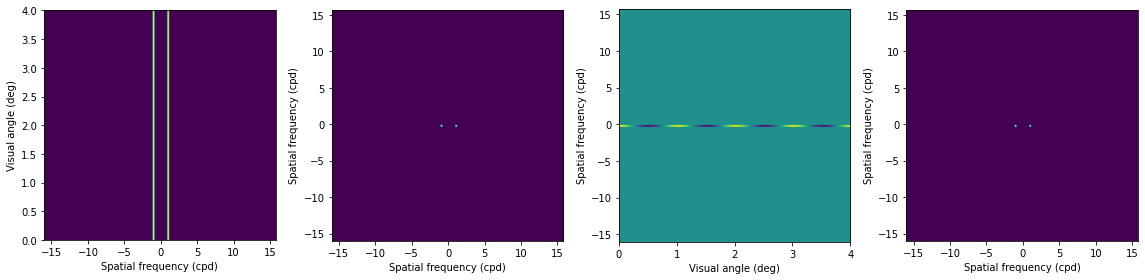

In [18]:
fig, axes = plt.subplots(1, 4, figsize=(16, 6))
axes[0].imshow(cosine_x, extent=(fL.min(), fL.max())+Lextent)
axes[0].set_aspect(fL.max() / T*2)
axes[0].set_xlabel('Spatial frequency (cpd)'), axes[0].set_ylabel('Visual angle (deg)')
axes[1].imshow(FLcos_xy, extent=(fL.min(), fL.max(),)*2)
axes[1].set_xlabel('Spatial frequency (cpd)'), axes[1].set_ylabel('Spatial frequency (cpd)')

axes[2].imshow(cosine_y, extent=Lextent+(fL.min(), fL.max()))
axes[2].set_aspect(T/2 / fL.max())
axes[2].set_xlabel('Visual angle (deg)'), axes[2].set_ylabel('Spatial frequency (cpd)')
axes[3].imshow(FLcos_yx, extent=(fL.min(), fL.max(),)*2)
axes[3].set_xlabel('Spatial frequency (cpd)'), axes[3].set_ylabel('Spatial frequency (cpd)')

fig.tight_layout()
plt.show()

Instead of manually performing the fft in both directions, there is a convenvience function called fft2 which does that for us.

In [19]:
# Perform 2d fft and calculate amplitude spectrum
FL_2d = np.fft.fftshift(scipy.fft.fft2(L_2d))
FLamp = np.abs(FL_2d) / np.size(L_2d)

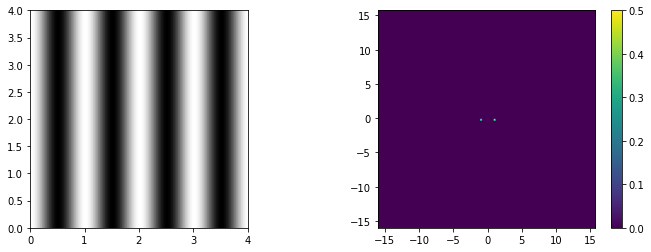

In [20]:
plt.figure(figsize=(12, 4))
plt.subplot(121), plt.imshow(L_2d, cmap='gray', extent=Lextent*2)
plt.subplot(122), plt.imshow(FLamp, extent=(fL.min(), fL.max(),)*2), plt.colorbar()
plt.show()

### 2d sine-wave gratings: orientation
When creating a 2d sine-wave grating, there are some additional parameters that we can vary.
Next to the parameters frequency, phase, amplitude and mean, we can also change the orientation of the sine-wave in 2d space.

In [21]:
# Parameters
ppd = 128.             # Spatial resolution, pixels per degree
extent = (-0.5, 0.5,)  # Visual extent in deg

nX = int(extent[1]*ppd - extent[0]*ppd)
x = np.linspace(extent[0], extent[1], nX, endpoint=False)
yy, xx = np.meshgrid(x, x)

f = scipy.fft.fftshift(scipy.fft.fftfreq(nX, d=(1/ppd)))
fy, fx = np.meshgrid(f, f)
fextent = (f.min(), f.max(),)

In [22]:
def grating(frequency, orientation=0., phase=0, amplitude=1., mean=0.):
    alpha = [np.cos(orientation), np.sin(orientation)]
    g = amplitude * np.sin((alpha[0]*xx + alpha[1]*yy) * 2. * np.pi * frequency + phase) + mean
    return g

In [23]:
def plot_gratings(frequency, orientation, phase, amplitude, mean):
    g = grating(frequency, orientation*np.pi/180., phase*np.pi/180, amplitude, mean)

    plt.figure(figsize=(10, 4))
    plt.imshow(g, cmap='gray', extent=extent*2), plt.colorbar()
    plt.xlabel('Visual angle (deg)'), plt.ylabel('Visual angle (deg)')

interactive(plot_gratings, frequency=(0.5, 10, 0.5), orientation=(0, 90), phase=(0,90),
            amplitude=(0, 2, 0.1), mean=(-1, 1, 0.1))

interactive(children=(FloatSlider(value=5.0, description='frequency', max=10.0, min=0.5, step=0.5), IntSlider(…

In [24]:
def plot_amplitude(g, helper_lines=False, frequency=None):
    gamp = np.abs(scipy.fft.fftshift(scipy.fft.fft2(g))) / np.size(g)
    if helper_lines and frequency is not None:
        f2d = np.round(np.sqrt(fy**2 + fx**2))
        circle = np.round(frequency) == f2d

    plt.figure(figsize=(16, 3))
    plt.subplot(141)
    plt.imshow(g, cmap='gray', extent=extent*2), plt.colorbar()
    plt.plot(extent, (0, 0), 'r'), plt.plot((0,0), extent, 'b')
    plt.xlabel('Visual angle (deg)'), plt.ylabel('Visual angle (deg)'), plt.title('2d grating')
    
    plt.subplot(142)
    plt.plot(x, g[int(nX/2), :], 'r'), plt.plot(x, g[:, int(nX/2)], 'b')
    plt.xlabel('Visual angle (deg)'), plt.title('Cut-throughs')
    
    plt.subplot(143)
    plt.imshow(gamp, extent=fextent*2), plt.colorbar(), plt.title('Amplitude spectrum')
    if helper_lines:
        plt.plot(fextent, (0, 0), 'w--', linewidth=0.5), plt.plot((0, 0), fextent, 'w--', linewidth=0.5)
        if frequency is not None:
            plt.plot(fx[circle], fy[circle], 'w.', markersize=0.5)
    
    plt.subplot(144)
    plt.imshow(np.log(gamp+0.001), extent=fextent*2), plt.colorbar(), plt.title('Amplitude spectrum (log)')
    if helper_lines:
        plt.plot(fextent, (0, 0), 'w--', linewidth=0.5), plt.plot((0, 0), fextent, 'w--', linewidth=0.5)
        if frequency is not None:
            plt.plot(fx[circle], fy[circle], 'w.', markersize=0.5)

### 2d Fourier transform of a vertical grating

In [25]:
# Example 1: Vertical grating
def vertical_grating(frequency, helper_lines):
    gv = grating(frequency, orientation=np.pi/2)
    plot_amplitude(gv, helper_lines)

interactive(vertical_grating, frequency=(1, 10, 1), helper_lines=False)

interactive(children=(IntSlider(value=5, description='frequency', max=10, min=1), Checkbox(value=False, descri…

### 2d Fourier transform of a horizontal grating

In [26]:
# Example 2: Horizontal grating
def horizontal_grating(frequency, helper_lines):
    gv = grating(frequency, orientation=0)
    plot_amplitude(gv, helper_lines)

interactive(horizontal_grating, frequency=(1, 10, 1), helper_lines=False)

interactive(children=(IntSlider(value=5, description='frequency', max=10, min=1), Checkbox(value=False, descri…

### 2d Fourier transform of an oblique grating

In [27]:
# Example 3: oblique grating
def oblique_grating(frequency, helper_lines):
    gv = grating(frequency, orientation=0.75*np.pi)
    plot_amplitude(gv, helper_lines, frequency)

interactive(oblique_grating, frequency=(1, 10, 1), helper_lines=False)

interactive(children=(IntSlider(value=5, description='frequency', max=10, min=1), Checkbox(value=False, descri…

In order to understand why the output for the oblique grating looks like it does,
let's visualize once more how the Fourier transform would look like in x and y
direction individually.

(Note: we look at the sine component in the following because the cosine component is comparatively tiny)

In [28]:
oblique_grating = grating(frequency=3, orientation=0.75*np.pi)

# Compute fft in x-direction
sinx = np.fft.fftshift(scipy.fft.fft2(oblique_grating, axes=1)).imag
sinxy = np.real(np.fft.fftshift(scipy.fft.fft2(scipy.fft.fft2(oblique_grating, axes=1), axes=0)).imag)

# Compute fft in y-direction
siny = np.fft.fftshift(scipy.fft.fft2(oblique_grating, axes=0)).imag
sinyx = np.real(np.fft.fftshift(scipy.fft.fft2(scipy.fft.fft2(oblique_grating, axes=0), axes=1)).imag)

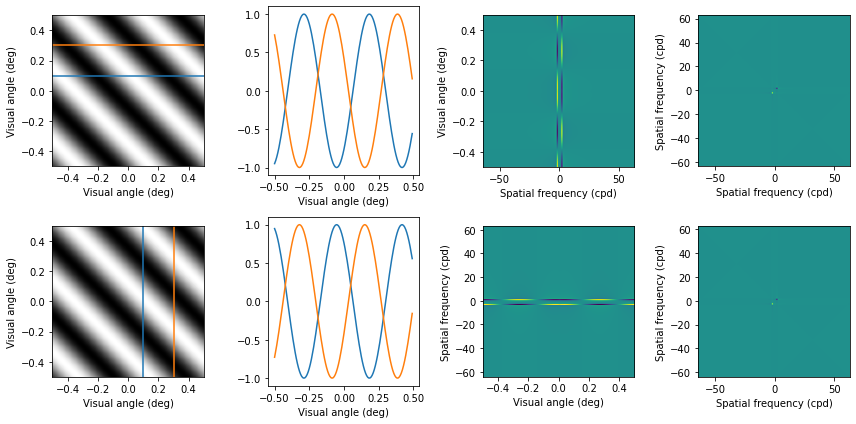

In [29]:
v1, v2 = 0.1, 0.3

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes[0,0].imshow(oblique_grating, cmap='gray', extent=extent*2)
axes[0,0].set_xlabel('Visual angle (deg)'), axes[0,0].set_ylabel('Visual angle (deg)')
axes[0,0].plot(extent, (v1, v1)), axes[0,1].plot(x, oblique_grating[int(v1*ppd), :])
axes[0,0].plot(extent, (v2, v2)), axes[0,1].plot(x, oblique_grating[int(v2*ppd), :])
axes[0,1].set_xlabel('Visual angle (deg)')
axes[0,2].imshow(sinx, extent=fextent+extent)
axes[0,2].set_aspect(f.max() / x.max())
axes[0,2].set_xlabel('Spatial frequency (cpd)'), axes[0,2].set_ylabel('Visual angle (deg)')
axes[0,3].imshow(sinxy, extent=fextent*2)
axes[0,3].set_xlabel('Spatial frequency (cpd)'), axes[0,3].set_ylabel('Spatial frequency (cpd)')

axes[1,0].imshow(oblique_grating, cmap='gray', extent=extent*2)
axes[1,0].set_xlabel('Visual angle (deg)'), axes[1,0].set_ylabel('Visual angle (deg)')
axes[1,0].plot((v1, v1), extent), axes[1,1].plot(x, oblique_grating[:, int(v1*ppd)])
axes[1,0].plot((v2, v2), extent), axes[1,1].plot(x, oblique_grating[:, int(v2*ppd)])
axes[1,1].set_xlabel('Visual angle (deg)')
axes[1,2].imshow(siny, extent=extent+fextent)
axes[1,2].set_aspect(x.max() / f.max())
axes[1,2].set_xlabel('Visual angle (deg)'), axes[1,2].set_ylabel('Spatial frequency (cpd)')
axes[1,3].imshow(sinyx, extent=fextent*2)
axes[1,3].set_xlabel('Spatial frequency (cpd)'), axes[1,3].set_ylabel('Spatial frequency (cpd)')

fig.tight_layout()
plt.show()

In order to decode the orientation and spatial frequency of the grating from
the amplitude spectrum, we create a vector with the peak frequencies `(fx_peak, fy_peak)`.
The spatial frequency of the grating is given by the `magnitude` of that vector.
The orientation is of the grating is given by the `direction` of that vector.

In [30]:
FLamp = np.abs(sinyx)

fy, fx = np.meshgrid(f, f)
fy_peak = np.abs(fy.flatten()[np.argmax(FLamp)])
fx_peak = np.abs(fx.flatten()[np.argmax(FLamp)])
magnitude = np.sqrt(fy_peak**2 + fx_peak**2)
direction = np.arctan2(fy_peak, fx_peak) * 180/np.pi

print("Magnitude of (fy_peak, fx_peak):", magnitude)
print("Direction of (fy_peak, fx_peak):", direction)

Magnitude of (fy_peak, fx_peak): 2.8284271247461903
Direction of (fy_peak, fx_peak): 45.0


### 2d Fourier transform of any oriented grating

Notice how due to the bleeding that we see in the amplitude spectra for oblique gratings,
we cannot always perfectly decode the spatial frequency of the grating based on the
magnitude of the peak frequency vector.

In [31]:
def plot_gratings(frequency, orientation, phase, amplitude, mean):
    # Generate sinusoid
    g = grating(frequency, orientation*np.pi/180., phase*np.pi/180, amplitude, mean)
    gamp = np.abs(scipy.fft.fftshift(scipy.fft.fft2(g))) / np.size(g)
    plot_amplitude(g, True, frequency)
    
    # Get peak frequency vector and calculate magnitude and direction
    fy_peak = np.abs(fy.flatten()[np.argmax(gamp)])
    fx_peak = np.abs(fx.flatten()[np.argmax(gamp)])
    magnitude = np.sqrt(fy_peak**2 + fx_peak**2)
    direction = np.arctan2(fy_peak, fx_peak) * 180/np.pi
    print("Magnitude of (fy_peak, fx_peak):", magnitude)
    print("Direction of (fy_peak, fx_peak):", direction)
    
interactive(plot_gratings, frequency=(0.5, 10, 0.5), orientation=(0, 90), phase=(0,90),
            amplitude=(0, 2, 0.1), mean=(-1, 1, 0.1))

interactive(children=(FloatSlider(value=5.0, description='frequency', max=10.0, min=0.5, step=0.5), IntSlider(…

## Reducing dimensionality - from 2d back to 1d
In many cases, working with 1d signals is easier than working with 2d signals.
There are several scenarios in which it is reasonable to reduce the dimensionality of
our 2d frequency spectra to 1d, e.g.
- for visualization purposes
- if input singals are circular symmetric (e.g. Gabors)
- if we want to know the overall ampltiude in individual frequency bands (i.e. averaged over orientation)

### Using cut-throughs
The easiest way to reduce the dimensionality is by using cut-throughs (here: vertical and horizontal).
This is particularly useful if you know the orientation of your signal in advance.
However, for orientations other than vertical and horizontal, getting the right cut-through is not very convenient, since we have to rotate our cut-through with the orientation of the grating.
Also, if our signal does not have all it's power within one orientation-band, we will lose information.

In [32]:
def plot_cuts(frequency, orientation):
    g = grating(frequency, orientation*np.pi/180.)
    gamp = np.abs(scipy.fft.fftshift(scipy.fft.fft2(g))) / np.size(g)
    gamp1d_x = gamp[int(nX/2), :]
    gamp1d_y = gamp[:, int(nX/2)]

    plt.figure(figsize=(16, 4))
    plt.subplot(131, aspect=1.), plt.imshow(g, cmap='gray', extent=extent*2)
    plt.ylabel('Visual angle (deg)'), plt.xlabel('Visual angle (deg)')

    plt.subplot(132)
    plt.imshow(np.log(gamp+0.001), extent=[f.min(), f.max(),]*2)
    plt.plot(fextent, (0, 0), 'r'), plt.plot((0, 0), fextent, 'b')
    plt.ylabel('SF (cpd)'), plt.xlabel('SF (cpd)'), plt.title('Amplitude spectrum (log)'), plt.colorbar()

    plt.subplot(133)
    plt.stem(f, gamp1d_x, linefmt='r', markerfmt='ro'), plt.stem(f, gamp1d_y, linefmt='b', markerfmt='bo')
    plt.title('Cut through'), plt.ylabel('Amplitude'), plt.xlabel('SF (cpd)')
    plt.show()

interactive(plot_cuts, frequency=(0.5, 10, 0.5), orientation=(0,180))

interactive(children=(FloatSlider(value=5.0, description='frequency', max=10.0, min=0.5, step=0.5), IntSlider(…

### Using radial-averaging
Radial averaging is the cleaner method to reduce the dimensionality of a 2d amplitude spectrum
by averaging the amplitude within orientation bands (i.e. along circles around the DC/origin).

In [33]:
def radial_average(amp, fx, fy, rounding_factor=0.5, only_full_circles=False):
    # create bins by rounding to int
    radii = np.sqrt(fx**2 + fy**2)
    radii = (radii / rounding_factor).astype(int)

    # creates bins from 0 to radii.max()
    sum_bins = np.bincount(radii.ravel(), amp.ravel())

    # count how often a radius is represented
    count_bins = np.bincount(radii.ravel())

    # mean of each radius bin
    means = np.ma.divide(sum_bins, count_bins)

    # radius each bin represents
    bins = np.arange(0, means.shape[0]) * rounding_factor
    
    # remove masked values
    bins = bins[~means.mask]
    means = means[~means.mask]

    if only_full_circles:
        max_bin = radii[int(radii.shape[0]/2), :].max()
        means = means[:max_bin]
        bins = bins[:max_bin]
    return means, bins

In [34]:
def plot_radial(frequency, orientation, helper_lines=False):
    g = grating(frequency, orientation*np.pi/180.)
    gamp = np.abs(scipy.fft.fftshift(scipy.fft.fft2(g))) / np.size(g)
    gamp_mean, f_mean = radial_average(gamp, fx, fy)

    plt.figure(figsize=(16, 4))
    plt.subplot(131, aspect=1.), plt.imshow(g, cmap='gray', extent=extent*2)
    plt.ylabel('Visual angle (deg)'), plt.xlabel('Visual angle (deg)')

    plt.subplot(132), plt.imshow(np.log(gamp+0.001), extent=fextent*2)
    plt.ylabel('SF (cpd)'), plt.xlabel('SF (cpd)'), plt.title('Amplitude spectrum (log)'), plt.colorbar()
    if helper_lines:
        plt.plot(fextent, (0, 0), 'w--', linewidth=0.5), plt.plot((0, 0), fextent, 'w--', linewidth=0.5)
        if frequency is not None:
            f2d = np.round(np.sqrt(fy**2 + fx**2))
            circle = np.round(frequency) == f2d
            plt.plot(fx[circle], fy[circle], 'w.', markersize=0.5)

    plt.subplot(133), plt.stem(f_mean, gamp_mean)
    plt.title('Radial average'), plt.ylabel('Amplitude'), plt.xlabel('SF (cpd)')
    plt.show()

interactive(plot_radial, frequency=(0.5, 10, 0.5), orientation=(0,180), helper_lines=False)

interactive(children=(FloatSlider(value=5.0, description='frequency', max=10.0, min=0.5, step=0.5), IntSlider(…

## Going beyond single sine-waves

### Compound signals

In [35]:
def plot_compound(f1, f2, o1, o2, helper_lines):
    compound = grating(f1, o1*np.pi/180., 0, 2, 1) + grating(f2, o2*np.pi/180., 0, 3., 0)
    plot_amplitude(compound, helper_lines, None)

interactive(plot_compound, f1=(1, 10, 1), o1=(0,180), f2=(1, 10, 1), o2=(90,270),helper_lines=False)

interactive(children=(IntSlider(value=5, description='f1', max=10, min=1), IntSlider(value=5, description='f2'…

### (Oriented) Gaussians

In [36]:
def gaussian2d(x, y, sigma, orientation=0):
    # determine a, b, c coefficients
    a = (np.cos(orientation)**2 / (2*sigma[0]**2)) + (np.sin(orientation)**2 / (2*sigma[1]**2))
    b = -(np.sin(2*orientation) / (4*sigma[0]**2)) + (np.sin(2*orientation) / (4*sigma[1]**2))
    c = (np.sin(orientation)**2 / (2*sigma[0]**2)) + (np.cos(orientation)**2 / (2*sigma[1]**2))

    # create Gaussian
    gaussian = np.exp(-(a*x**2 + 2*b*x*y + c*y**2))
    return gaussian

In [37]:
def plot_gauss(sigmax, sigmay, orientation, helper_lines):
    gauss = gaussian2d(xx, yy, sigma=[sigmax, sigmay], orientation=orientation*np.pi/180.)
    plot_amplitude(gauss, helper_lines, None)

interactive(plot_gauss, sigmax=(0.01, 0.2, 0.01), sigmay=(0.01, 0.2, 0.01), orientation=(0,180), helper_lines=False)

interactive(children=(FloatSlider(value=0.09999999999999999, description='sigmax', max=0.2, min=0.01, step=0.0…

### Gabors / Windowed sine-wave gratings
Good localization in image-space and good attributes in frequency domain.

In [38]:
def plot_gabor(frequency, orientation, sigma, helper_lines):
    gabor = grating(frequency, orientation=orientation*np.pi/180.) * gaussian2d(xx, yy, sigma=[sigma, sigma])
    plot_amplitude(gabor, helper_lines, None)

interactive(plot_gabor, frequency=(1, 10), orientation=(0,180), sigma=(0.01, 0.2, 0.01), helper_lines=False)

interactive(children=(IntSlider(value=5, description='frequency', max=10, min=1), IntSlider(value=90, descript…

### Square-wave grating
Peaks in amplitude spectrum at so-called odd-harmonics, i.e. odd multiples of the fundamental frequency of the grating.

In [39]:
def plot_edges(frequency, orientation, helper_lines):
    edge = grating(frequency, orientation=orientation*np.pi/180.)
    edge[edge<=0] = -1
    edge[edge>0] = 1
    plot_amplitude(edge, helper_lines, frequency)

interactive(plot_edges, frequency=(1, 10), orientation=(0,180), helper_lines=False)

interactive(children=(IntSlider(value=5, description='frequency', max=10, min=1), IntSlider(value=90, descript…

### Natural images
Natural images have a very specific frequency spectrum which amplitude decrease with increasing spatial frequency.
Let's look at one example from the UPenn natural image database.

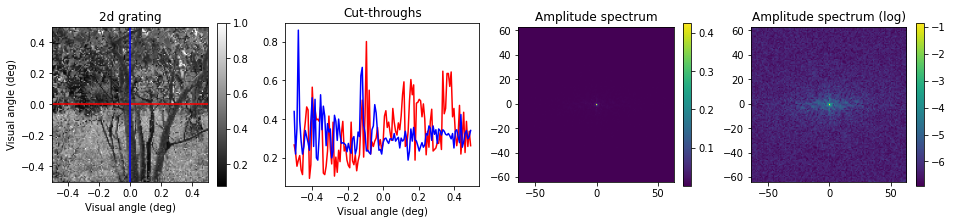

In [40]:
# Import natural image, crop to squared shape and resize
img = cv2.imread('upenn_natural_image_database_DSC_0004.JPG')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = img[0:np.minimum(img.shape[0], img.shape[1]), 0:np.minimum(img.shape[0], img.shape[1])]
img = cv2.resize(img, [nX, nX]) / 255
plot_amplitude(img, False, None)

As you can see, natural images have most power at low spatial frequencies and
gradually less power towards higher spatial frequencies.
This gradual decrease is often referred to as a 1/f spectrum which is
characteristic for any natural image.

Let's look into this more closely by reducing the dimensionality of the amplitude spectrum to 1d
and directly comparing it to a spectrum which is defined as `1/(f**exponent)` where the
exponent is typically a value betwen 1-2.

In [41]:
img_power = np.abs(scipy.fft.fftshift(scipy.fft.fft2(img))) ** 2
impower_mean, fm = radial_average(img_power, fx, fy)

# Remove 0cpd to avoid division by zero
impower_mean = impower_mean[fm!=0]
fm = fm[fm!=0]

# Generate a vector which is 1/(frequency**exponent)
power_1f = 1 / (fm**1.8)

# Normalize by max-power
impower_norm = impower_mean / impower_mean.max()
power_1f_norm = power_1f / power_1f.max()

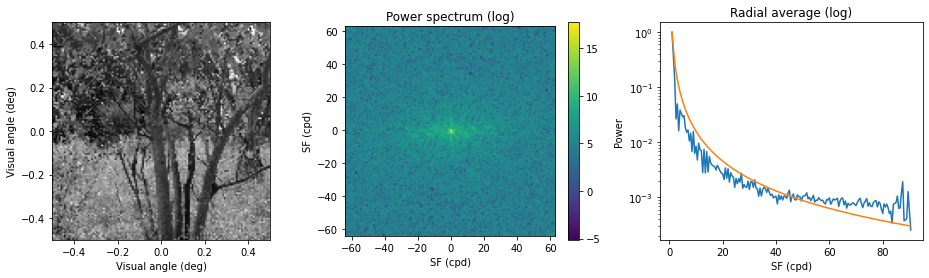

In [42]:
plt.figure(figsize=(16, 4))
plt.subplot(131, aspect=1.), plt.imshow(img, cmap='gray', extent=extent*2)
plt.ylabel('Visual angle (deg)'), plt.xlabel('Visual angle (deg)')

plt.subplot(132), plt.imshow(np.log(img_power+0.001), extent=fextent*2)
plt.ylabel('SF (cpd)'), plt.xlabel('SF (cpd)'), plt.title('Power spectrum (log)'), plt.colorbar()

plt.subplot(133)
plt.plot(fm, impower_norm, label='Natural image')
plt.plot(fm, power_1f_norm, label='')
plt.title('Radial average (log)'), plt.ylabel('Power'), plt.xlabel('SF (cpd)'), plt.yscale('log')
plt.show()

## Defining signals in frequency-space

So far, we have mainly looked at images that were defined in image space and have looked at their
frequency spectra.

However, sometimes it is more convenient to define signals in frequency space directly and
transform them to image space via the inverse Fourier transformation.

Let's look at two examples for that.

### Example 1: Create a sine-wave grating

In [43]:
# Define an amplitude spectrum which is 0 everywhere except at fy=0, fx=3
sin_freq = 3.
sin_amp = np.zeros([nX, nX], dtype=complex)
sin_amp[np.round(fx) == sin_freq] = (nX*nX)*1j
sin_amp[np.round(fx) == -sin_freq] = (-nX*nX)*1j
sin_amp[fy != 0] = 0

# Perform ifft
sin_ifft = np.real(scipy.fft.ifft2(scipy.fft.ifftshift(sin_amp)))

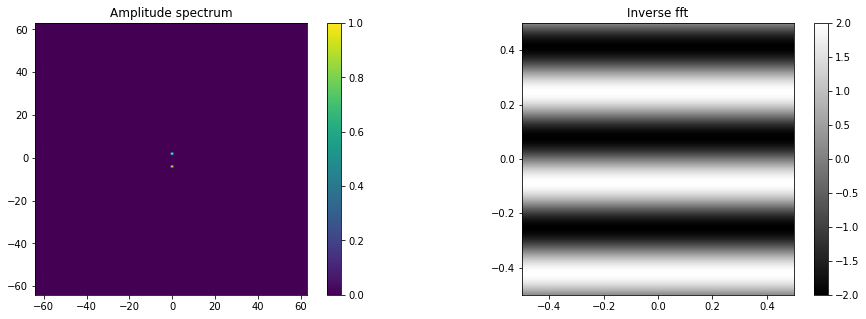

In [44]:
plt.figure(figsize=(16, 5))
plt.subplot(121)
plt.imshow(np.abs(sin_amp) / np.size(sin_amp), extent=fextent*2), plt.colorbar(), plt.title("Amplitude spectrum")

plt.subplot(122)
plt.imshow(sin_ifft, extent=extent*2, cmap='gray'), plt.colorbar(), plt.title("Inverse fft")
plt.show()

### Example 2: Create 1/f noise

In [45]:
# Create random (=white) noise
white_fft = np.random.rand(nX, nX) - 0.5 + (np.random.rand(nX, nX) - 0.5)*1j

# Calculate 2d-frequency-array
f2d = np.sqrt(fx**2 + fy**2)
f2d[f2d == 0 ] = 1 # needed to avoid division by 0

# Generate 1/f noise
noise1f_fft = white_fft / f2d * nX**2
noise1f_fft[f2d == 0] = 0

# Perform ifft
noise1f_ifft = np.real(scipy.fft.ifft2(scipy.fft.ifftshift(noise1f_fft)))

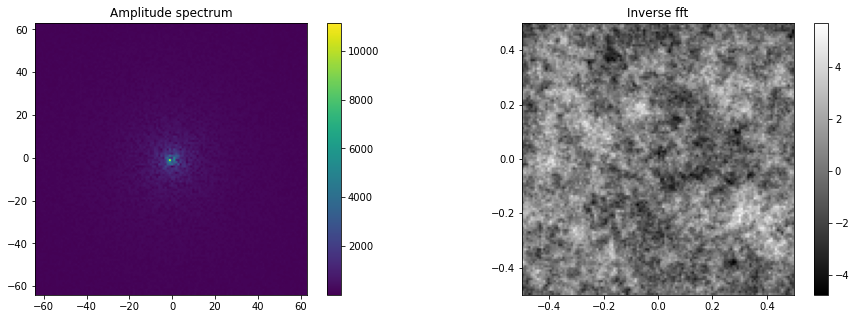

In [46]:
plt.figure(figsize=(16, 5))
plt.subplot(121)
plt.imshow(np.abs(noise1f_fft), extent=fextent*2), plt.colorbar(), plt.title("Amplitude spectrum")

plt.subplot(122)
plt.imshow(noise1f_ifft, extent=extent*2, cmap='gray'), plt.colorbar(), plt.title("Inverse fft")
plt.show()

## Modulating signals in frequency-space: Adding, subtracting, multiplying

For a list of correspondences between the time / space domain and the frequency domain, check e.g. https://measurebiology.org/wiki/Assignment_8,_Part_0:_convolution_practice

### Summation / Subtraction
According to the principle of linearity, a summation in the image domain corresponds to a summation in the frequency domain.
Let's check this correspondence using two Gabors.

In [47]:
# Example 1: Create two Gabors in the image domain
g1 = grating(10., orientation=np.pi/4) * gaussian2d(xx, yy, sigma=[0.15, 0.15], orientation=np.pi/4)
g2 = grating(2., orientation=np.pi/7) * gaussian2d(xx, yy, sigma=[0.15, 0.15], orientation=np.pi/4)

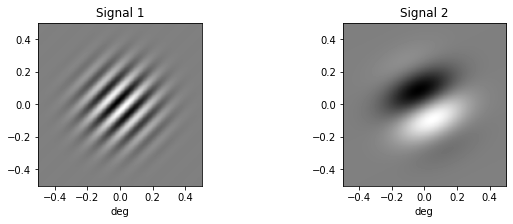

In [48]:
plt.figure(figsize=(10, 3))
plt.subplot(121)
plt.imshow(g1, cmap='gray', extent=extent*2), plt.title('Signal 1'), plt.xlabel('deg')
plt.subplot(122)
plt.imshow(g2, cmap='gray', extent=extent*2), plt.title('Signal 2'), plt.xlabel('deg')
plt.show()

In [49]:
# Perform fft
g1_fft = scipy.fft.fft2(g1)
g2_fft = scipy.fft.fft2(g2)

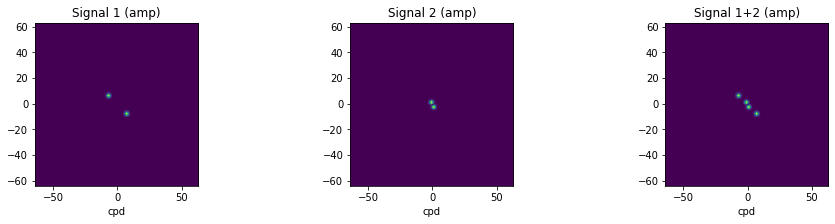

In [50]:
# Plot amplitude spectra
plt.figure(figsize=(16, 3))
plt.subplot(131), plt.imshow(np.abs(scipy.fft.fftshift(g1_fft)), extent=fextent*2)
plt.title('Signal 1 (amp)'), plt.xlabel('cpd')
plt.subplot(132), plt.imshow(np.abs(scipy.fft.fftshift(g2_fft)), extent=fextent*2)
plt.title('Signal 2 (amp)'), plt.xlabel('cpd')
plt.subplot(133), plt.imshow(np.abs(scipy.fft.fftshift(g1_fft+g2_fft)), extent=fextent*2)
plt.title('Signal 1+2 (amp)'), plt.xlabel('cpd')
plt.show()

In [51]:
# Version 1: Sum the gratings in the image domain
g_sum1 = g1 + g2

# Version 2: Perform inverse fft of summed frequency spectra
g_sum_fft = g1_fft + g2_fft
g_sum2 = np.real(scipy.fft.ifft2(g_sum_fft))

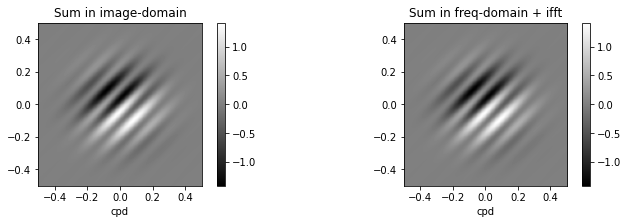

In [52]:
plt.figure(figsize=(12, 3))
plt.subplot(121), plt.imshow(g_sum1, cmap='gray', extent=extent*2)
plt.colorbar(), plt.title('Sum in image-domain'), plt.xlabel('cpd')
plt.subplot(122), plt.imshow(g_sum2, cmap='gray', extent=extent*2)
plt.colorbar(), plt.title('Sum in freq-domain + ifft'), plt.xlabel('cpd')
plt.show()

This holds true for any kind of signal.
To show this, let's visualize how summing two signals looks for natural images.

In [53]:
# Example 2: Read two images
im1 = cv2.cvtColor(cv2.imread('monroe.png'), cv2.COLOR_BGR2GRAY)
im2 = cv2.cvtColor(cv2.imread('einstein.png'), cv2.COLOR_BGR2GRAY)

# For convenience, we resize the images to the same shape/size as the grating
im1 = cv2.resize(im1, [nX, nX]) / 255
im2 = cv2.resize(im2, [nX, nX]) / 255

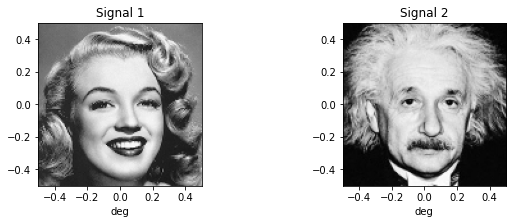

In [54]:
plt.figure(figsize=(10, 3))
plt.subplot(121)
plt.imshow(im1, cmap='gray', extent=extent*2), plt.title('Signal 1'), plt.xlabel('deg')
plt.subplot(122)
plt.imshow(im2, cmap='gray', extent=extent*2), plt.title('Signal 2'), plt.xlabel('deg')
plt.show()

In [55]:
# Perform fft and visualize amplitude spectra
im1_fft = scipy.fft.fft2(im1)
im2_fft = scipy.fft.fft2(im2)

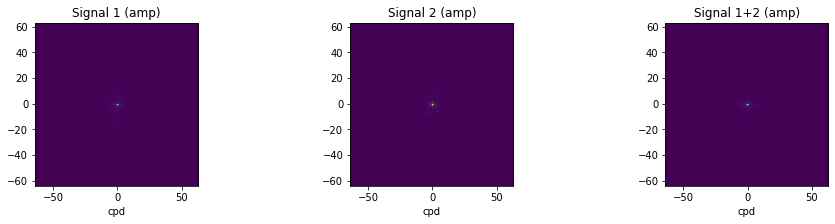

In [56]:
# Plot amplitude spectra
plt.figure(figsize=(16, 3))
plt.subplot(131), plt.imshow(np.abs(scipy.fft.fftshift(im1_fft)), extent=fextent*2)
plt.title('Signal 1 (amp)'), plt.xlabel('cpd')
plt.subplot(132), plt.imshow(np.abs(scipy.fft.fftshift(im2_fft)), extent=fextent*2)
plt.title('Signal 2 (amp)'), plt.xlabel('cpd')
plt.subplot(133), plt.imshow(np.abs(scipy.fft.fftshift(im1_fft+im2_fft)), extent=fextent*2)
plt.title('Signal 1+2 (amp)'), plt.xlabel('cpd')
plt.show()

In [57]:
# Version 1: Sum the gratings in the image domain
im_sum1 = im1 + im2

# Version 2: Sum the frequency spectra and perform inverse fft
im_sum2 = np.real(scipy.fft.ifft2(im1_fft + im2_fft))

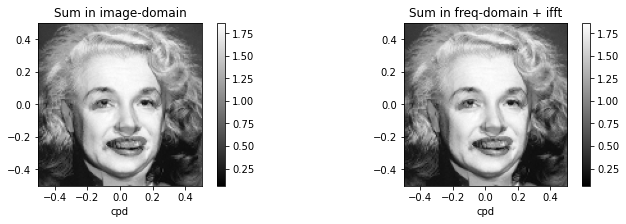

In [58]:
plt.figure(figsize=(12, 3))
plt.subplot(121), plt.imshow(im_sum1, cmap='gray', extent=extent*2)
plt.colorbar(), plt.title('Sum in image-domain'), plt.xlabel('cpd')
plt.subplot(122), plt.imshow(im_sum2, cmap='gray', extent=extent*2)
plt.colorbar(), plt.title('Sum in freq-domain + ifft'), plt.xlabel('cpd')
plt.show()

### Multiplication of two frequency spectra (=filtering in image domain)
A multiplication in the frequency domain corresponds to a convolution in the image domain and vice versa.
This correspondence is very useful and used a lot in vision sciences, among other things because
multiplications are computationally more convenient than convolutions.

A convolution is the area under the product of two signals.
An example can be seen in the following.
In the example a 5x5 image (or `input`) is convolved with a 3x3 image (or `filter`).
At each location of the output (here: convolved feature), a value is obtained by multiplying
the image and the filter element-wise and summing all values involved in the multiplication.
This procedure is repeated for each element of the input image by sliding the filter over the whole image.

 <img src="https://ibm.box.com/shared/static/fvutcm8jwa5j2o7xv2zzqyz2yu3zwhz4.gif" alt="HTML5 Icon" style="width: 450px; height: 300px;">
<center>  Animations showing how a kernel interact with a matrix representing an image. <a href="http://cs231n.github.io/convolutional-networks/">ref</a></center>  

Let's see how the Fourier transform can help us to speed up this process.
For demonstration purposes, let's use the two gratings that we defined previously, and let's use
a small portion of the grating as filter.

In [59]:
# Generate filter from signal itself
ystart, xstart = int(0.44*ppd), int(0.35*ppd)
fsize = int(0.13*ppd)
filt = im2[ystart:ystart+fsize, xstart:xstart+fsize]

# Filters and/or signal should have a zero-mean, otherwise they respond most to mean intensity
filt = filt - filt.mean()

In [60]:
# Version 1: Convolution in image space
import scipy.signal
im2_filt1 = scipy.signal.convolve2d(im2, filt, 'same')
im2_filt2 = scipy.ndimage.convolve(im2, filt, mode="constant", origin=-1)

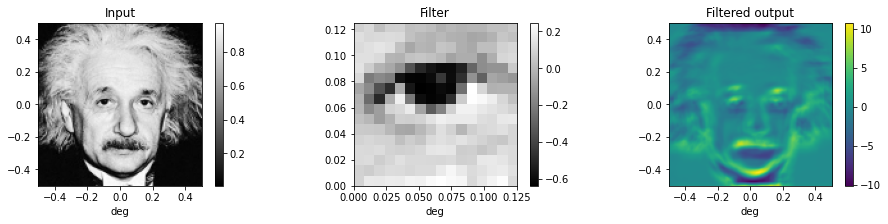

In [61]:
plt.figure(figsize=(16, 3))
plt.subplot(131), plt.imshow(im2, cmap='gray', extent=extent*2)
plt.colorbar(), plt.title('Input'), plt.xlabel('deg')

plt.subplot(132), plt.imshow(filt, cmap='gray', extent=(0, fsize/ppd)*2)
plt.colorbar(), plt.title('Filter'), plt.xlabel('deg')

plt.subplot(133), plt.imshow(im2_filt1, extent=extent*2)
plt.colorbar(), plt.title('Filtered output'), plt.xlabel('deg')
plt.show()

In [62]:
# Add zero-padding to make the filter the same size as image (needed for multiplication)
filt_pad = np.pad(filt, int(im2.shape[0]/2 - filt.shape[0]/2))

# Perform fft of filter
filt_fft = scipy.fft.fft2(filt_pad)

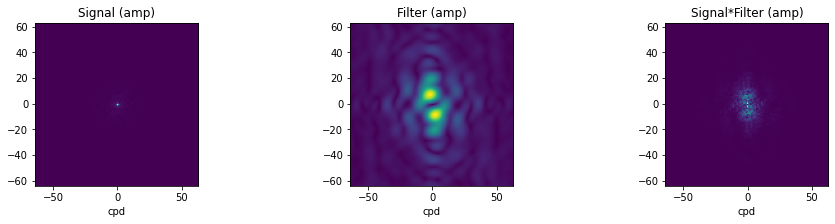

In [63]:
plt.figure(figsize=(16, 3))
plt.subplot(131)
plt.imshow(np.abs(scipy.fft.fftshift(im2_fft)), extent=fextent*2), plt.title('Signal (amp)'), plt.xlabel('cpd')
plt.subplot(132)
plt.imshow(np.abs(scipy.fft.fftshift(filt_fft)), extent=fextent*2), plt.title('Filter (amp)'), plt.xlabel('cpd')
plt.subplot(133)
plt.imshow(np.abs(scipy.fft.fftshift(im2_fft*filt_fft)), extent=fextent*2), plt.title('Signal*Filter (amp)'), plt.xlabel('cpd')
plt.show()

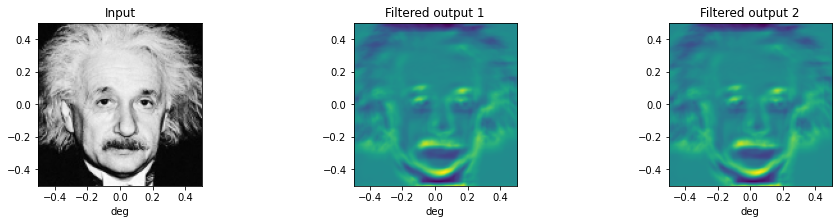

In [64]:
# Version 2: Multiplication in frequency space and ifft
im2_filt2 = np.real(scipy.fft.ifft2(im2_fft * filt_fft))
im2_filt2 = scipy.fft.ifftshift(im2_filt2) # Shift needed because filter origin is assumed to be in image corner

plt.figure(figsize=(16, 3))
plt.subplot(131),plt.imshow(im2, cmap='gray', extent=extent*2), plt.title('Input'), plt.xlabel('deg')
plt.subplot(132), plt.imshow(im2_filt1, extent=extent*2), plt.title('Filtered output 1'), plt.xlabel('deg')
plt.subplot(133), plt.imshow(im2_filt1, extent=extent*2), plt.title('Filtered output 2'), plt.xlabel('deg')
plt.show()

### RMS contrast in image and frequency space
Demonstrate the relationship between RMS contrast (root-mean-squared contrast) in the image and frequency domain.
There is a direct correspondence between the RMS contrast (root-mean-squared contrast) of an image
and the spectral power of the image.
For a constant mean intensity (for simplicity, we use 0 here), we can calculate the spectral power
of an image by computing it's contrast energy which is `rms**2 / area`.

In [65]:
# Compute rms contrast, contrast energy and power for image 1:
sig1 = im1
sig1 = sig1 - sig1.mean()
sig1_fft = scipy.fft.fft2(sig1)
sig1_power = np.abs(sig1_fft)**2.

sig1_rms = sig1.std()
sig1_cenergy = sig1_rms**2 * np.size(sig1)
sig1_mpower = sig1_power.mean()

print("RMS contrast:", sig1_rms)
print("Contrast energy:", sig1_cenergy)
print("Mean power:", sig1_mpower)

RMS contrast: 0.24961461019345613
Contrast energy: 1020.8453201433567
Mean power: 1020.8453201433568


In [66]:
# Compute rms contrast, contrast energy and power for image 2:
sig2 = im2
sig2 = sig2 - sig2.mean()
sig2_fft = scipy.fft.fft2(sig2)
sig2_power = np.abs(sig2_fft)**2.

sig2_rms = sig2.std()
sig2_cenergy = sig2_rms**2 * np.size(sig2)
sig2_mpower = sig2_power.mean()

print("RMS contrast:", sig2_rms)
print("Contrast energy:", sig2_cenergy)
print("Mean power:", sig2_mpower)

RMS contrast: 0.3197157219757898
Contrast energy: 1674.7420529213525
Mean power: 1674.7420529213523


This relationship is very useful in vision science, particularly when generating stimuli.
In experiments, we often want to make sure that the stimulus power is the same
if we want to compare sensitivity to a number of stimuli.
Because of this relationship, keeping the rms-contrast constant between different stimuli
is equal to keeping the power of these stimuli constant and vice versa.

Let's make our two example images have equal power by adapting the rms contrast of image 2.

In [67]:
sig2a = sig2 / sig2_rms * sig1_rms
sig2a_fft = scipy.fft.fft2(sig2a)
sig2a_power = np.abs(sig2a_fft)**2.

sig2a_rms = sig2a.std()
sig2a_cenergy = sig2a_rms**2 * np.size(sig2a)
sig2a_mpower = sig2a_power.mean()

print("RMS contrast:", sig2a_rms)
print("Contrast energy:", sig2a_cenergy)
print("Mean power:", sig2a_mpower)

RMS contrast: 0.24961461019345613
Contrast energy: 1020.8453201433567
Mean power: 1020.8453201433567


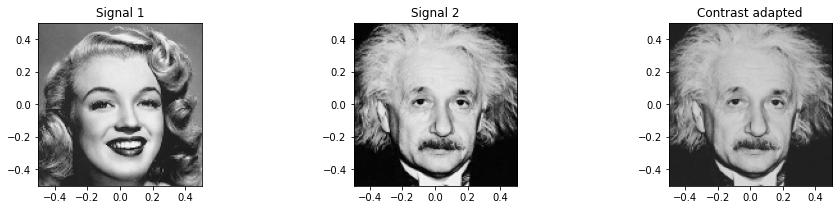

In [68]:
plt.figure(figsize=(16, 3))
plt.subplot(131), plt.imshow(sig1, cmap='gray', extent=extent*2, vmin=-0.5, vmax=0.5), plt.title('Signal 1')
plt.subplot(132), plt.imshow(sig2, cmap='gray', extent=extent*2, vmin=-0.5, vmax=0.5), plt.title('Signal 2')
plt.subplot(133), plt.imshow(sig2a, cmap='gray', extent=extent*2, vmin=-0.5, vmax=0.5), plt.title('Contrast adapted')
plt.show()

## Some relevant filters

To demonstrate some relevant filters, let's use some example inputs:
- (1) A compound grating
- (2) A natural image

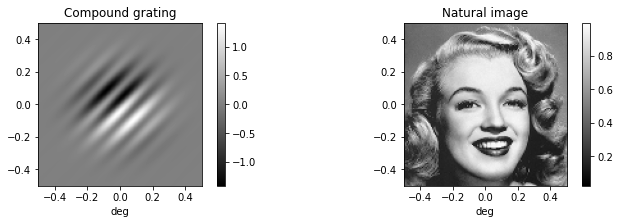

In [69]:
plt.figure(figsize=(12, 3))
plt.subplot(121), plt.imshow(g_sum1, cmap='gray', extent=extent*2)
plt.colorbar(), plt.title('Compound grating'), plt.xlabel('deg')
plt.subplot(122), plt.imshow(im1, cmap='gray', extent=extent*2)
plt.colorbar(), plt.title('Natural image'), plt.xlabel('deg')
plt.show()

In [70]:
def plot_filt(s1, s1_filt, s2, s2_filt):
    plt.figure(figsize=(16, 3))
    plt.subplot(141), plt.imshow(s1, cmap='gray', extent=extent*2)
    plt.colorbar(), plt.title('Signal 1'), plt.xlabel('deg')
    plt.subplot(142), plt.imshow(s1_filt, cmap='gray', extent=extent*2)
    plt.colorbar(), plt.title('Signal 1 - filt'), plt.xlabel('deg')
    plt.subplot(143), plt.imshow(s2, cmap='gray', extent=extent*2)
    plt.colorbar(), plt.title('Signal 2'), plt.xlabel('deg')
    plt.subplot(144), plt.imshow(s2_filt, cmap='gray', extent=extent*2)
    plt.colorbar(), plt.title('Signal 2 - filt'), plt.xlabel('deg')
    plt.show()

### "Ideal" filters: Lowpass, bandpass, highpass
These filters are most conveniently defined in the frequency domain.
They are sometimes called "ideal" filters because they perfectly remove the desired frequency-contents, i.e.
they are 0 at every frequency that should be removed and they are 1 at every frequency that should persist.

We call a filter `lowpass` if it only removes frequency contents above a certain frequency (i.e. low-frequency information passes).

Conversely, we call a filter `highpass` if it only removes frequency contents below a certain frequency (i.e. high-frequency information passes).

We call a filter `bandpass` if a desired range of frequency contents pass.

In [71]:
def ideal_filter(fx, fy, bounds):
    fxy = np.sqrt(fx**2 + fy**2)
    bandpass = np.ones(fxy.shape)
    if bounds[0] is not None:
        bandpass[fxy<[bounds[0]]] = 0
    if bounds[1] is not None:
        bandpass[fxy>[bounds[1]]] = 0
    return bandpass

def plot_ideal(flow, fhigh):
    ideal = ideal_filter(fx, fy, [flow, fhigh])
    
    plt.figure()
    plt.imshow(ideal, extent=fextent*2), plt.xlabel('deg'), plt.colorbar()
    plt.show()

interactive(plot_ideal, flow=(-1, ppd/2), fhigh=(10, ppd*0.7))

interactive(children=(FloatSlider(value=31.5, description='flow', max=64.0, min=-1.0), FloatSlider(value=49.8,…

We can use the ideal filter to selectively filter out one of the sine-wave gratings that
make up our compound grating.

As we have previously seen, natural images are broadband signals that have power in a wide range of
spatial frequency bands.
We can use the ideal filter to demonstrate what the different frequency contents in the natural image
correspond to.

In [72]:
def ideal_filtering(flow, fhigh):
    ideal = ideal_filter(fx, fy, [flow, fhigh])
    
    # Filter grating
    gfilt_fft = g_sum_fft*scipy.fft.ifftshift(ideal)
    gfilt = np.real(scipy.fft.ifft2(gfilt_fft))
    
    # Filter natural iamge
    imfilt_fft = im1_fft*scipy.fft.ifftshift(ideal)
    imfilt = np.real(scipy.fft.ifft2(imfilt_fft))
    
    plot_filt(g_sum1, gfilt, im1, imfilt)

interactive(ideal_filtering, flow=(-1, ppd/4), fhigh=(0.5, ppd/2))

interactive(children=(FloatSlider(value=15.5, description='flow', max=32.0, min=-1.0), FloatSlider(value=32.25…

### Gaussian filters: smoothing

In [73]:
def gauss_filtering(sigma):
    gauss = gaussian2d(xx, yy, sigma=[sigma, sigma])
    gauss_fft = scipy.fft.fft2(gauss)
    
    # Filter grating
    gfilt_fft = g_sum_fft*gauss_fft
    gfilt = np.real(scipy.fft.ifftshift(scipy.fft.ifft2(gfilt_fft)))
    
    # Filter natural iamge
    imfilt_fft = im1_fft*gauss_fft
    imfilt = np.real(scipy.fft.ifftshift(scipy.fft.ifft2(imfilt_fft)))
    
    plot_filt(g_sum1, gfilt, im1, imfilt)

interactive(gauss_filtering, sigma=(0.01, 0.1, 0.01))

interactive(children=(FloatSlider(value=0.05, description='sigma', max=0.1, min=0.01, step=0.01), Output()), _…

### Difference-of-Gaussian (DoG) filters

In [74]:
def create_odog(xx, yy, sigma_c, sigma_s, orientation):
    # Create center and surround anisotropic Gaussian filters
    center = gaussian2d(xx, yy, sigma=sigma_c, orientation=orientation)
    surround = gaussian2d(xx, yy, sigma=sigma_s, orientation=orientation)

    # Normalize each filter by its total sum
    center = center / center.sum()
    surround = surround / surround.sum()
    return center - surround

In [75]:
def plot_dog(sigma_c, sigma_s):
    dog = create_odog(xx, yy, (sigma_c, sigma_c), (sigma_s, sigma_s), 0)
    plt.imshow(dog, extent=extent*2, cmap='coolwarm')

interactive(plot_dog, sigma_c=(0.01, 0.1, 0.01), sigma_s=(0.02, 0.2, 0.01))

interactive(children=(FloatSlider(value=0.05, description='sigma_c', max=0.1, min=0.01, step=0.01), FloatSlide…

In [76]:
def dog_filtering(sigma_c, sigma_s):
    dog = create_odog(fx, fy, (sigma_c, sigma_c), (sigma_s, sigma_s), 0)
    dog_fft = scipy.fft.fft2(dog)
    
    # Filter grating
    gfilt_fft = g_sum_fft*dog_fft
    gfilt = np.real(scipy.fft.ifftshift(scipy.fft.ifft2(gfilt_fft)))
    
    # Filter natural iamge
    imfilt_fft = im1_fft*dog_fft
    imfilt = np.real(scipy.fft.ifftshift(scipy.fft.ifft2(imfilt_fft)))
    
    plot_filt(g_sum1, gfilt, im1, imfilt)

interactive(dog_filtering, sigma_c=(0.02, 0.2, 0.01), sigma_s=(0.04, 0.4, 0.01))

interactive(children=(FloatSlider(value=0.11, description='sigma_c', max=0.2, min=0.02, step=0.01), FloatSlide…

### Oriented DoG filters

In [79]:
def plot_odog(sigma_c, orientation):
    odog = create_odog(xx, yy, (sigma_c, sigma_c), (sigma_c, sigma_c*2), orientation*np.pi/180.)
    plt.imshow(odog, extent=extent*2, cmap='coolwarm')

interactive(plot_odog, sigma_c=(0.01, 0.1, 0.01), orientation=(0, 90))

interactive(children=(FloatSlider(value=0.05, description='sigma_c', max=0.1, min=0.01, step=0.01), IntSlider(…

In [81]:
def odog_filtering(sigma_c, orientation):
    odog = create_odog(xx, yy, (sigma_c, sigma_c), (sigma_c, sigma_c*2), orientation*np.pi/180.)
    odog_fft = scipy.fft.fft2(odog)
    
    # Filter grating
    gfilt_fft = g_sum_fft*odog_fft
    gfilt = np.real(scipy.fft.ifftshift(scipy.fft.ifft2(gfilt_fft)))
    
    # Filter natural iamge
    imfilt_fft = im1_fft*odog_fft
    imfilt = np.real(scipy.fft.ifftshift(scipy.fft.ifft2(imfilt_fft)))
    
    plot_filt(g_sum1, gfilt, im1, imfilt)

interactive(odog_filtering, sigma_c=(0.001, 0.02, 0.001), orientation=(0, 90))

interactive(children=(FloatSlider(value=0.010000000000000002, description='sigma_c', max=0.02, min=0.001, step…